# MTG Deck builder

In [108]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

In [109]:
from deep_mtg.tools import RulesRetriever, CardsRetriever

In [110]:
from pathlib import Path

rules_retriever = RulesRetriever(Path('../data/MagicCompRules 20241108.pdf'))
cards_retriever = CardsRetriever(Path('../data/cards'))

Loaded 1236 document splits.
Loading ../data/cards/FDN.json...
Loaded 515 cards from set ../data/cards/FDN.json.


In [139]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import operator
from typing import Annotated, List, Literal, TypedDict, Optional

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
import json

# class Card(BaseModel):
#     name: str = Field(description="Card name")
#     # type: Annotated[str, ..., "Card type"]
#     cost: Optional[str|int] = Field(default=None, description="Card cost, if applicable")
#     text: Optional[str] = Field(default=None, description="Card text, if applicable")
#     power: Optional[str|int] = Field(default=None, description="Card power, if applicable")
#     toughness: Optional[str|int] = Field(default=None, description="Card toughness, if applicable")

# class DeckState(BaseModel):
#     prompt: str = Field(description="Prompt for the deck")
#     cards: list[Card] = Field(description="List of cards in the deck")
#     n_cards: int = Field(description="Number of cards in the deck")
#     # n_lands: Annotated[int, 0, "Number of lands in the deck"]
#     # n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
#     # n_other: Annotated[int, 0, "Number of other cards in the deck"]

class DeckCard(TypedDict):
    name: Annotated[str, ..., "Card name"]
    types: Annotated[str, ..., "Card type"]
    cost: Annotated[str, ..., "Card cost, including mana colors, if applicable"]
    text: Annotated[str, ..., "Card text, if applicable"]
    power: Annotated[int, ..., "Card power, if applicable"]
    toughness: Annotated[int, ..., "Card toughness, if applicable"]

class QueryCard(TypedDict):
    colours: Annotated[Optional[str], ..., "Mana colours of the card, if applicable"]
    convertedManaCost: Annotated[int, ..., "Converted mana cost of the card, if applicable"]
    keywords: Annotated[Optional[list[str]], ..., "List of keywords of the card, if applicable"]
    manaCost: Annotated[str, ..., "Mana cost of the card, including colours, if applicable"]
    name: Annotated[str, ..., "Card name"]
    power: Annotated[int, ..., "Card power, if applicable"]
    rarity: Annotated[str, ..., "Card rarity [Common, Uncommon, Rare, Mythic Rare]"]
    subtypes: Annotated[Optional[list[str]], ..., "List of subtypes of the card, if applicable"]
    text: Annotated[str, ..., "Card text, if applicable"]
    toughness: Annotated[int, ..., "Card toughness, if applicable"]
    types: Annotated[str, ..., "Card type"]

class DeckState(TypedDict):
    prompt: Annotated[str, ..., "Deck theme prompt"]
    cards: Annotated[list[DeckCard], [], "List of cards in the deck"]
    n_cards: Annotated[int, 0, "Number of cards in the deck"]
    # n_lands: Annotated[int, 0, "Number of lands in the deck"]
    # n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
    # n_other: Annotated[int, 0, "Number of other cards in the deck"]

In [172]:
def build_deck(deck_state: DeckState) -> DeckState:
    while deck_state['n_cards'] < 60:
        card = get_card(deck_state)
        deck_state['cards'].append(card)
        deck_state['n_cards'] += 1
        # if card['type'].lower() == 'land':
        #     deck_state['n_lands'] += 1
        # elif 'creature' in card['type'].lower():
        #     deck_state['n_creatures'] += 1
        # else:
        #     deck_state['n_other'] += 1
        print(f'Deck contains {deck_state["n_cards"]} cards')
    return deck_state

card_tools_llm = llm.bind_tools([rules_retriever, cards_retriever])
card_advisor_llm = card_tools_llm.with_structured_output(DeckCard)
card_advisor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Magic: The Gathering deck builder."
            "You are advising on building a high-competitative 60-card deck with a theme of {prompt}. "
            "Given the current state of the deck, provide a description of what card should be added next."
            "If the deck is empty, suggest a starting card that would be a good fit for the theme."
            "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description."
            "Only describe one card at a time."
            "Remember, the deck should have 60 cards, including lands, and you need to suggest which lands to add."
            "When choosing the card, consider the following: "
            "1. The card should be a good fit for the deck theme."
            "2. The card should be a good fit for the current state of the deck."
            "3. The card should be a good fit for the current metagame."
            "4. What is the card's role in the deck?"
            "5. What is the card's impact on the game?"
            "6. What is the card's synergy with other cards in the deck?"
            "7. What is the card's synergy with the deck's strategy?"
            "8. What current weaknesses in the deck does the card address?"
            "9. What current strengths in the deck does the card enhance?"
            "10. What is the card's mana cost and colour?"
        ),
        (
            "user",
            "The current deck consists of {n_cards} cards"#, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
            "The cards present are: {cards}."
        ),
    ]
)

card_query_llm = card_tools_llm.with_structured_output(QueryCard)
card_query_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm specializing in Magic: The Gathering. "
            "Only extract relevant information from the card description. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value,"
        ),
        (
            "user",
            "{prompt}"
        ),
    ]
)

def get_card(deck_state: DeckState) -> DeckCard:
    
    desired_card = None
    fails = 0
    while desired_card is None:
        if fails > 5:
            desired_card = card_tools_llm.invoke(card_advisor_prompt.invoke({"prompt": deck_state['prompt'], 
                                 "n_cards": deck_state['n_cards'], 
                                #  "n_lands": deck_state.n_lands,
                                #    "n_creatures": deck_state.n_creatures,
                                #      "n_other": deck_state.n_other, 
                                     "cards": deck_state['cards']})
            ).content
            break
        desired_card = card_advisor_llm.invoke(card_advisor_prompt.invoke({"prompt": deck_state['prompt'], 
                                 "n_cards": deck_state['n_cards'], 
                                #  "n_lands": deck_state.n_lands,
                                #    "n_creatures": deck_state.n_creatures,
                                #      "n_other": deck_state.n_other, 
                                     "cards": deck_state['cards']}))
        fails += 1
        
    print('Recommended card:', desired_card)
    
    card_query = None
    fails = 0
    while card_query is None:
        if fails > 5:
            card_query = card_tools_llm.invoke(card_query_prompt.invoke({"prompt": desired_card})).content
            break
        card_query = card_query_llm.invoke(card_query_prompt.invoke({"prompt": desired_card}))
        fails += 1
        
    card = json.loads(cards_retriever.invoke({'query': json.dumps(card_query), 'k':1})[0])
    print('Matching card:', card)

    return DeckCard(name=card['name'],
                 types=card['types'],
                   cost=card['manaCost'], 
                   text=card['text'], 
                   power=card['power'],
                     toughness=card['toughness'])



In [173]:
card_tools_llm.invoke(card_advisor_prompt.invoke({"prompt": "zombies", "n_cards": 0, "cards": []})).content

''

In [174]:
get_card(
    DeckState(prompt="zombies", cards=[], n_cards=0, 
                #    n_lands=0, n_creatures=0, n_other=0
                   )
)

Recommended card: {'cost': '', 'name': 'Zombie Queen', 'power': 0, 'text': '', 'toughness': 0, 'types': ''}
Matching card: {'colors': ['B'], 'convertedManaCost': 4, 'keywords': None, 'manaCost': '{3}{B}', 'manaValue': 4, 'name': 'Highborn Vampire', 'power': '4', 'rarity': 'common', 'subtypes': ['Vampire', 'Warrior'], 'supertypes': [], 'text': None, 'toughness': '3', 'types': ['Creature']}


{'name': 'Highborn Vampire',
 'types': ['Creature'],
 'cost': '{3}{B}',
 'text': None,
 'power': '4',
 'toughness': '3'}

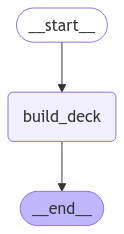

In [175]:
from IPython.display import Image, display

graph = StateGraph(DeckState)
graph.add_node('build_deck', build_deck)
graph.add_edge(START, 'build_deck')
graph.add_edge("build_deck", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [176]:
deck = app.invoke({'prompt': 'blue-white control deck that mills the opponent', 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0})

Recommended card: {'cost': '', 'name': 'None', 'power': 0, 'text': '', 'toughness': 0, 'types': 'land'}
Matching card: {'colors': ['W'], 'convertedManaCost': 1, 'keywords': None, 'manaCost': '{W}', 'manaValue': 1, 'name': 'Savannah Lions', 'power': '2', 'rarity': 'uncommon', 'subtypes': ['Cat'], 'supertypes': [], 'text': None, 'toughness': '1', 'types': ['Creature']}
Deck contains 1 cards
Recommended card: {'cost': '{U}', 'name': 'Island', 'power': '', 'text': '', 'toughness': '', 'types': 'Land'}
Matching card: {'colors': ['G'], 'convertedManaCost': 2, 'keywords': None, 'manaCost': '{1}{G}', 'manaValue': 2, 'name': 'Bear Cub', 'power': '2', 'rarity': 'common', 'subtypes': ['Bear'], 'supertypes': [], 'text': None, 'toughness': '2', 'types': ['Creature']}
Deck contains 2 cards
Recommended card: {'cost': '{3}{U}', 'name': 'Isolated Watcher', 'power': 2, 'text': 'Flying\nEnchanted creature has lifelink.\nAt the beginning of your end step, if an opponent lost life this turn, create a 2/2 w

In [15]:
def get_response(prompt):
    for step in app.stream(
        {"prompt": "A blue-white control deck"}, stream_mode="updates"
    ):
        print(step)

In [ ]:
get_response("Using the SetsRetriever tool to retrieve valid cards, gradually construct a 60-card deck")